In [5]:
# TODO: This needs to be updated to use mutation AA positions rather than residue position
from biopandas.pdb import PandasPdb
# pdf = PandasPdb().read_pdb('/home/pphaneuf/iML1515_GP/iML1515_GP/genes/b3926/b3926_protein/structures/GLPK_ECOLI_model1_clean.pdb')
pdf = PandasPdb().read_pdb('../data/pdb_files/KPYK1_ECOLI_model1_clean.pdb')  # From iML1515
adf = pdf.df['ATOM']
cadf = adf[adf["atom_name"]=="CA"]
cadf = cadf.set_index("residue_number")
cadf = cadf[cadf["alt_loc"].isin(['A', ''])]  # removing the 'B' residue alternative locations. I could also find the average between the two positions if necessary to account for both.
cadf.head()

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,insertion,blank_3,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
residue_number,,,,,,,,,,,,,,,,,,,,
1,ATOM,2,,CA,,MET,,X,,,-17.124,9.151,94.383,0.0,74.18,,1SG,C,NaN,1
2,ATOM,10,,CA,,LYS,,X,,,-13.670,9.604,92.938,0.0,142.84,,1SG,C,NaN,9
3,ATOM,19,,CA,,LYS,,X,,,-11.232,11.309,95.268,0.0,74.17,,1SG,C,NaN,18
4,ATOM,28,,CA,,THR,,X,,,-8.478,11.977,92.760,0.0,62.70,,1SG,C,NaN,27
5,ATOM,35,,CA,,LYS,,X,,,-8.811,14.945,90.461,0.0,105.62,,1SG,C,NaN,34


In [6]:
import pandas as pd

aa_mut_cnt_df = pd.read_csv("./pykF_pub_aa_muts.csv")
aa_mut_cnt_df.head()

,AA position,mutation count,name,color,study,study color
0,20,1,MOB AA 20,#CF000F,TOL_isobutyric_acid,#9467BD
1,20,1,MOB AA 20,#CF000F,tpiAKO,#F7B6D2
2,25,1,SNP AA 25,black,TOL_putrescine,#C5B0D5
3,37,1,SNP AA 37,#FFA500,tpiHSA,#2AB0C1
4,69,1,SNP AA 69,#8C564B,tpiHSA,#2AB0C1


In [7]:
gff_df = pd.read_csv("./PykF_feats.csv")
gff_df = gff_df[~(gff_df.feature.isin(["Turn", "Helix", "Beta strand", "Barrel domain", "Alpha/beta domain"]))].copy()
gff_df.head()

,seqname,source,feature,start,end,score,strand,frame,attribute,9,color
0,P0AD61,UniProtKB,Chain,1,470,.,.,.,ID=PRO_0000112069;Note=Pyruvate kinase I,NaN,white
1,P0AD61,UniProtKB,ATP binding site,34,37,.,.,.,Note=ATP;Ontology_term=ECO:0000250;evidence=EC...,NaN,#FFC125
2,P0AD61,UniProtKB,Potassium binding site,34,34,.,.,.,Note=Potassium;Ontology_term=ECO:0000250;evide...,NaN,#76EE00
3,P0AD61,UniProtKB,Potassium binding site,36,36,.,.,.,Note=Potassium;Ontology_term=ECO:0000250;evide...,NaN,#76EE00
4,P0AD61,UniProtKB,Potassium binding site,66,66,.,.,.,Note=Potassium;Ontology_term=ECO:0000250;evide...,NaN,#76EE00


In [8]:
aa_mut_cnt_df = aa_mut_cnt_df[aa_mut_cnt_df["color"] != '#CF000F'].copy()  # filtering out all truncating mutations since currently not considering truncations for 3D clustering

In [9]:
dist_aa_df = aa_mut_cnt_df.copy()

# don't care about about multiple muts on same AA for now
dist_aa_df = dist_aa_df[["AA position", "name"]]
dist_aa_df = dist_aa_df.drop_duplicates()
# display(dist_aa_df)

for _, r in gff_df.iterrows():
    if r["feature"] != "Chain":
        for aa in range(r["start"], r["end"] + 1): 
            dist_aa_df = dist_aa_df.append({"AA position":aa, "name": r["feature"] + " AA " + str(aa)}, ignore_index=True)

dist_aa_df["AA position"] = dist_aa_df["AA position"].astype(int)

# PykF using includes the initiator methionine.
dist_aa_df["residue index"] = dist_aa_df["AA position"] # - 1  # this really depends on the structure being used. Double check if the initiator methionine is included in structure.

dist_aa_df['coords'] = dist_aa_df.apply(lambda r:
                                        [
                                            cadf.at[r["residue index"], "x_coord"],
                                            cadf.at[r["residue index"], "y_coord"],
                                            cadf.at[r["residue index"], "z_coord"],
                                        ],
                                        axis=1)
dist_aa_df.head()

,AA position,name,residue index,coords
0,25,SNP AA 25,25,"[-19.639, 16.039, 83.813]"
1,37,SNP AA 37,37,"[1.055, 26.334, 71.35]"
2,69,SNP AA 69,69,"[10.095, 26.909, 79.325]"
3,129,SNP AA 129,129,"[15.355, 9.613, 68.956]"
4,174,SNP AA 174,174,"[7.472, 32.815, 79.0]"


In [10]:
import numpy as np
def _get_dist_mat_label(r):
    lbl = r["name"]
    if ("SNP" in r["name"]) or ("INS" in r["name"]):
        lbl = "mut AA " + str(r["AA position"])
    return lbl
        

dist_aa_df['dist mat label'] = dist_aa_df.apply(lambda r: _get_dist_mat_label(r), axis=1)
# dist_aa_df = dist_aa_df.set_index("AA position")
dist_aa_df = dist_aa_df.set_index("dist mat label")

dist_aa_df.head()

,AA position,name,residue index,coords
dist mat label,,,,
mut AA 25,25,SNP AA 25,25,"[-19.639, 16.039, 83.813]"
mut AA 37,37,SNP AA 37,37,"[1.055, 26.334, 71.35]"
mut AA 69,69,SNP AA 69,69,"[10.095, 26.909, 79.325]"
mut AA 129,129,SNP AA 129,129,"[15.355, 9.613, 68.956]"
mut AA 174,174,SNP AA 174,174,"[7.472, 32.815, 79.0]"


In [11]:
import numpy as np


def get_3D_res_dist(feat_res_1, feat_res_2):
    dist = np.nan
    feat_res_1_coords = dist_aa_df.at[feat_res_1, "coords"]
    feat_res_2_coords = dist_aa_df.at[feat_res_2, "coords"]
    dist = np.sqrt((feat_res_2_coords[0] - feat_res_1_coords[0])**2
                      + (feat_res_2_coords[1] - feat_res_1_coords[1])**2
                      + (feat_res_2_coords[2] - feat_res_1_coords[2])**2)
    return dist


dist_mat = pd.DataFrame(np.nan, columns=dist_aa_df.index, index=dist_aa_df.index)
for ir in dist_mat.index:
    for ic in dist_mat.columns:
        dist_mat.at[ir, ic] = get_3D_res_dist(ir, ic)
dist_mat.head()

dist mat label,mut AA 25,mut AA 37,mut AA 69,mut AA 129,mut AA 174,mut AA 220,mut AA 226,mut AA 245,mut AA 246,mut AA 278,...,PykF subunit interface AA 255,PykF subunit interface AA 256,PykF subunit interface AA 257,PykF subunit interface AA 291,PykF subunit interface AA 292,PykF subunit interface AA 293,PykF subunit interface AA 294,PykF subunit interface AA 295,PykF subunit interface AA 296,PykF subunit interface AA 297
dist mat label,,,,,,,,,,,,,,,,,,,,,
mut AA 25,0.000000,26.259380,31.975143,38.556503,32.242913,27.811948,35.962685,28.465521,30.478017,23.017023,...,36.549008,32.897821,31.349366,23.373135,24.379261,25.807561,22.604063,20.592931,23.648296,23.832205
mut AA 37,26.259380,0.000000,12.068672,22.131721,11.903938,17.695057,24.219207,18.924541,17.929071,17.153030,...,30.352662,27.144545,28.873167,27.552797,30.521643,29.107843,25.826522,27.743433,29.970166,27.267893
mut AA 69,31.975143,12.068672,0.000000,20.840714,6.470440,10.119221,13.844056,16.181417,13.184425,16.268349,...,23.948755,21.591428,24.052471,30.628819,32.684250,30.165042,27.336540,29.393283,30.262525,26.732342
mut AA 129,38.556503,22.131721,20.840714,0.000000,26.483135,21.982284,22.113285,13.058393,12.693388,17.661287,...,19.580160,18.357043,21.312404,23.254461,25.513162,22.599739,22.026009,25.724485,25.872862,23.189981
mut AA 174,32.242913,11.903938,6.470440,26.483135,0.000000,14.654327,19.100487,21.971959,19.332105,21.008836,...,30.065423,27.576021,29.712806,34.971009,37.179521,35.043936,31.883754,33.564942,34.850815,31.511138


In [12]:
df = gff_df[["feature", "color"]].drop_duplicates()
feat_to_color_d = dict()
for _, r in df.iterrows():
    feat_to_color_d[r["feature"]] = r["color"]
feat_to_color_d

{'Chain': 'white',
 'ATP binding site': '#FFC125',
 'Potassium binding site': '#76EE00',
 'Magnesium binding site': '#42d4f4',
 'Substrate binding site': '#911EB4',
 'Transition state stabilizer': '#4169E1',
 'N6-acetyllysine site': '#FA8072',
 'PykF subunit interface': '#88D27A'}

In [13]:
AA_feat_dist_df = dist_mat[dist_mat.index.str.contains("mut")]
AA_feat_dist_df = AA_feat_dist_df.T
AA_feat_dist_df = AA_feat_dist_df[~(AA_feat_dist_df.index.str.contains("mut"))]

col_colors = []
for _, r in AA_feat_dist_df.iterrows():
    col_colors.append(feat_to_color_d[r.name[:r.name.find(" AA")]])
# col_colors

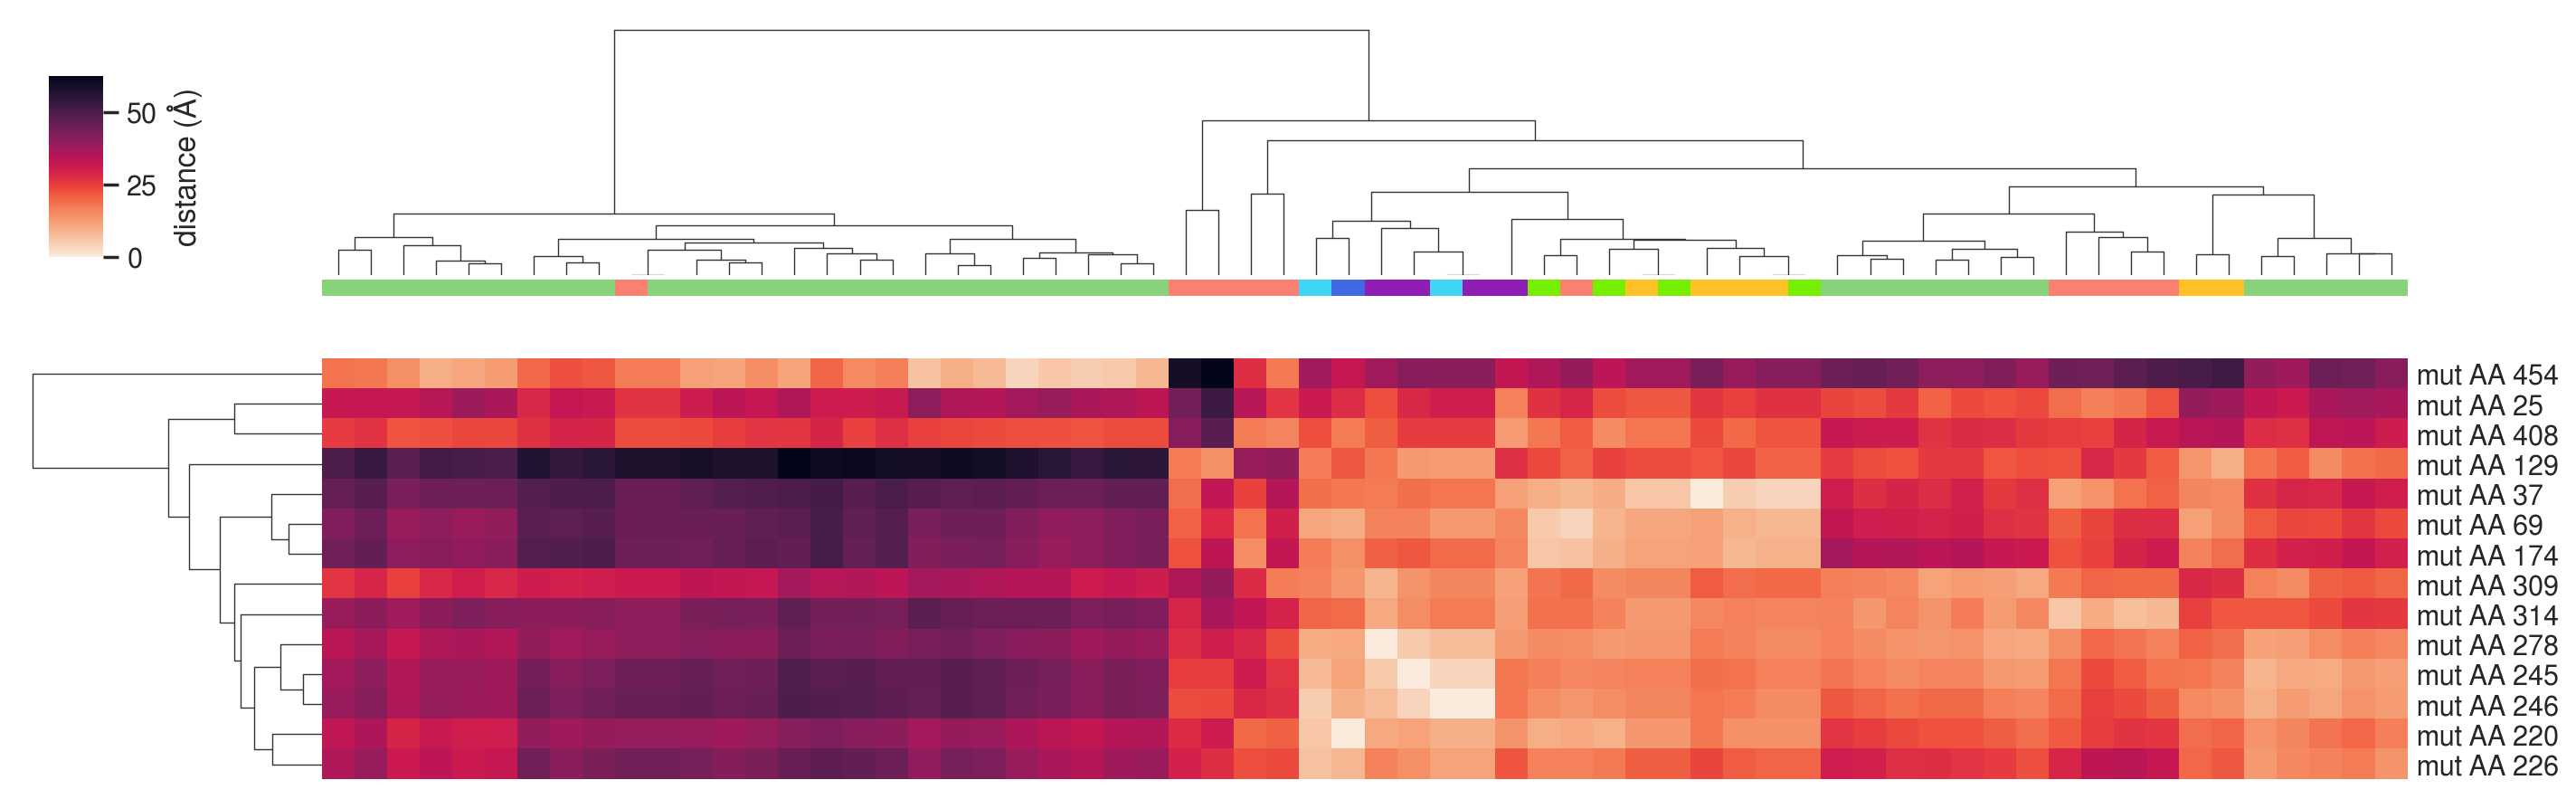

In [14]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as mpl
%matplotlib inline
mpl.rcParams["figure.dpi"] = 200
mpl.rcParams['font.sans-serif'] = ["FreeSans"]
sns.set_context("paper")
sns.set_style("white")
sns.set(font="FreeSans")

df = AA_feat_dist_df.T
cm = sns.clustermap(
    df,
#     linewidths=0.1,
    cbar_kws={'label': 'distance (Å)'},
    cbar_pos=(0.05, 0.85, 0.03, 0.10),
    yticklabels=True,
    xticklabels=True,
#     annot=True,
    cmap="rocket_r",
    col_colors=col_colors,
#     figsize=(10,10)
)
# Fix for recent matplotlib/seaborn issue
cm.ax_heatmap.set_ylim(len(df)+0, -0)

# Below is for adjusting the sizes of the dendograms and heatmaps
H = 0.425
W = 1.7
y0_offset = 0.29
x0_offset = 0.01
hm = cm.ax_heatmap.get_position()
# mpl.setp(cm.ax_heatmap.yaxis.get_majorticklabels(),fontsize=6)
# mpl.setp(cm.ax_heatmap.xaxis.get_majorticklabels(),fontsize=6)
col_dendo = cm.ax_col_dendrogram.get_position()
cm.ax_col_dendrogram.set_position([
    col_dendo.x0 + x0_offset,
    col_dendo.y0,
    col_dendo.width*W,
    col_dendo.height*1
])
row_dendo = cm.ax_row_dendrogram.get_position()
cm.ax_row_dendrogram.set_position([
    row_dendo.x0 + 0.015,
    row_dendo.y0 + y0_offset,
    row_dendo.width*1,
    row_dendo.height*H
])
cm.ax_heatmap.set_position([
    hm.x0 + x0_offset,
    hm.y0 + y0_offset,
    hm.width*W,
    hm.height*H
])
col_color_pos = cm.ax_col_colors.get_position()
cm.ax_col_colors.set_position([
    col_color_pos.x0 + 0.01,
    col_color_pos.y0 + 0.01,
    col_color_pos.width*W,
    col_color_pos.height*H
])

# mpl.setp(cm.ax_heatmap.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
cm.ax_heatmap.set_ylabel('')
cm.ax_heatmap.set_xlabel('')
cm.ax_heatmap.set_xticks([])
cm.ax_heatmap.tick_params(axis='both', which='both', length=0)
# cm.fig.suptitle("3D distance between mutated AA and small active sites on GlpK", y=0.92, x=0.6)

In [15]:
mut_aa_feat_prox_df = pd.DataFrame()
df = AA_feat_dist_df.T
for mut_aa, r in df.iterrows():
    min_dist_feats = r[r==r.min()]
    for feat_AA, min_dist in min_dist_feats.iteritems():
        feat = feat_AA[:feat_AA.find(" AA ")]
        mut_aa_feat_prox_df = mut_aa_feat_prox_df.append({"mut AA": mut_aa.replace("mut AA ", ''), "nearest feature": feat}, ignore_index=True)
mut_aa_feat_prox_df

mut_aa_feat_prox_df.to_pickle("./mut_aa_feat_prox_df.pkl")

In [16]:
gene_mut_df = pd.read_pickle("./pykF_mut_df.pkl")
gene_mut_df.head()

,COG links,COGs,Details,EC number links,EC numbers,Mutation Type,Position,RBS,Reference Seq,Sequence Change,...,tech_rep,temperature,terminator,mutation size,truncation,AA range,subgenic features,AA change,conservation (SIFT),stability (ΔΔGpred)
0,{'Carbohydrate transport and metabolism': ['EC...,[{'name': 'Carbohydrate transport and metaboli...,K286* (AAA→TAA),"{'2.7.1.40': ['ECK120014561', 'ECK120014561', ...","[{'name': '2.7.1.40', 'significantly associate...",SNP,1756553.0,{},NaN,A→T,...,1.0,42 celsius,{},1,True,"(286, 286)","{N6-acetyllysine site, Barrel domain}",K286*,False,False
1,{'Carbohydrate transport and metabolism': ['EC...,[{'name': 'Carbohydrate transport and metaboli...,K286* (AAA→TAA),"{'2.7.1.40': ['ECK120014561', 'ECK120014561', ...","[{'name': '2.7.1.40', 'significantly associate...",SNP,1756553.0,{},NaN,A→T,...,1.0,42 celsius,{},1,True,"(286, 286)","{N6-acetyllysine site, Barrel domain}",K286*,False,False
2,{'Carbohydrate transport and metabolism': ['EC...,[{'name': 'Carbohydrate transport and metaboli...,K286* (AAA→TAA),"{'2.7.1.40': ['ECK120014561', 'ECK120014561', ...","[{'name': '2.7.1.40', 'significantly associate...",SNP,1756553.0,{},NaN,A→T,...,1.0,42 celsius,{},1,True,"(286, 286)","{N6-acetyllysine site, Barrel domain}",K286*,False,False
3,{'Carbohydrate transport and metabolism': ['EC...,[{'name': 'Carbohydrate transport and metaboli...,T278S (ACC→TCC),"{'2.7.1.40': ['ECK120014561', 'ECK120014561', ...","[{'name': '2.7.1.40', 'significantly associate...",SNP,1756529.0,{},NaN,A→T,...,1.0,42 celsius,{},1,False,"(278, 278)","{Beta strand, Substrate binding site, Barrel d...",T278S,True,False
4,{'Carbohydrate transport and metabolism': ['EC...,[{'name': 'Carbohydrate transport and metaboli...,E250* (GAA→TAA),"{'2.7.1.40': ['ECK120014561', 'ECK120014561', ...","[{'name': '2.7.1.40', 'significantly associate...",SNP,1756445.0,{},NaN,G→T,...,1.0,37 celsius,{},1,True,"(250, 250)","{Helix, Barrel domain}",E250*,False,False


In [17]:
mut_aa_feat_prox_df = mut_aa_feat_prox_df.set_index("mut AA")
mut_aa_feat_prox_df

,nearest feature
mut AA,
25,Substrate binding site
37,ATP binding site
69,N6-acetyllysine site
129,ATP binding site
174,Potassium binding site
220,Transition state stabilizer
226,Magnesium binding site
245,Substrate binding site
246,Magnesium binding site


In [18]:
non_trunc_aa_mut_effect_df = pd.DataFrame(columns=["mutated AA", "functionally disruptive", "structurally disruptive", "nearest feature"])
for _, m in gene_mut_df.iterrows():
    if m["AA range"][0] == m["AA range"][1]:
        aa = m["AA range"][0]
        for _, r in mut_aa_feat_prox_df[mut_aa_feat_prox_df.index==str(aa)].iterrows():
            non_trunc_aa_mut_effect_df = non_trunc_aa_mut_effect_df.append({
                "mutated AA": aa,
                "functionally disruptive": m["conservation (SIFT)"],
                "structurally disruptive": m["stability (ΔΔGpred)"],
                "nearest feature": r["nearest feature"]},
                ignore_index=True)
    else:
        for aa in m["AA range"]:
            for _, r in mut_aa_feat_prox_df[mut_aa_feat_prox_df.index==str(aa)].iterrows():
                non_trunc_aa_mut_effect_df = non_trunc_aa_mut_effect_df.append({
                    "mutated AA": aa,
                    "functionally disruptive": m["conservation (SIFT)"],
                    "structurally disruptive": m["stability (ΔΔGpred)"],
                    "nearest feature": r["nearest feature"]},
                    ignore_index=True)

non_trunc_aa_mut_effect_df["unknown"] = non_trunc_aa_mut_effect_df.apply(lambda r: True if ((r["functionally disruptive"]==False) & (r["structurally disruptive"]==False)) else False, axis=1)
non_trunc_aa_mut_effect_df.head()

,mutated AA,functionally disruptive,structurally disruptive,nearest feature,unknown
0,278,True,False,Substrate binding site,False
1,309,True,False,Substrate binding site,False
2,314,True,False,N6-acetyllysine site,False
3,129,True,True,ATP binding site,False
4,174,True,True,Potassium binding site,False


In [19]:
non_trunc_aa_mut_effect_df.to_pickle("./PykF_mut_res_df.pkl")  # Since this also describes the frequency of mutated residues, using it to described freq mut res per feat.

In [20]:
cnt_columns = ["unknown", "functionally disruptive", "structurally disruptive"]
feat_mut_eff_cnt_d = {f:{"functionally disruptive":0, "structurally disruptive":0, "unknown":0} for f in non_trunc_aa_mut_effect_df["nearest feature"].unique()}
for nf, gdf in non_trunc_aa_mut_effect_df.groupby("nearest feature"):
    for _, r in gdf.iterrows():
        f = r["nearest feature"]
        for c in cnt_columns:
            feat_mut_eff_cnt_d[f][c] += int(r[c])

feat_mut_eff_cnt_df = pd.DataFrame(feat_mut_eff_cnt_d).T
feat_mut_eff_cnt_df["total"] = feat_mut_eff_cnt_df.sum(axis=1)
feat_mut_eff_cnt_df

,functionally disruptive,structurally disruptive,unknown,total
Substrate binding site,4,0,2,6
N6-acetyllysine site,2,1,0,3
ATP binding site,2,1,0,3
Potassium binding site,1,1,0,2
Magnesium binding site,2,1,0,3
PykF subunit interface,1,0,0,1
Transition state stabilizer,1,1,0,2


In [21]:
# feat_mut_eff_cnt_df.to_pickle("./pykF_mut_nearest_feat_df.pkl")  # The old name given is of an inappropraite context. Keeping this as comment to search out in other NBs and fix.
feat_mut_eff_cnt_df.to_pickle("./pykF_feat_mut_eff_cnt_df.pkl")